# Setup

In [131]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize
import statsmodels.api as sm

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0_mle, beta0_mle = np.load(f)
    

Instead of loading data we will just start from scratch.

In [109]:
from pybaseball.lahman import batting
from pybaseball.lahman import pitching

# Get the data
batting_data = batting()
pitching_data = pitching()

# Add player's name
def add_name(ID):
    _player = _players.loc[_players.key_bbref.isin([ID]),:]
    if not _player.empty:
        try:
            fname = _player.name_first.item().capitalize() #if type(_player.name_first.item())==str  else "NaN "
            lname = _player.name_last.item().capitalize() #if type(_player.name_last.item())==str  else "NaN "
            name = fname + ' ' + lname
        except:
            print(_player)

    else:
        name = " "
    return  name

# Get names of players
_players = pybaseball.playerid_reverse_lookup(batting_data.playerID.tolist(),key_type='bbref')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Remove unneeded columns
rows_to_keep = (batting_data.AB>0) & (batting_data.lgID == "NL") & (batting_data.yearID > 1980)
cols_to_keep = ["AB","H","playerID","yearID"]

# There are multiple rows for each player so group by player and get total H and AB, and take mean of years
bd = batting_data.loc[rows_to_keep ,cols_to_keep].groupby(by="playerID",as_index=True).agg({"AB": "sum", "H": "sum", "yearID": "mean"}).reset_index()#.sum().reset_index()

# Add the player's name for ease of reading
bd["Name"] = bd.apply(lambda row: add_name(row.playerID),axis=1)

# Add batting average
bd["Avg"] = bd.H / bd.AB

# Is pitcher?
bd.loc[:,"Pitcher"] = bd.playerID.isin(pitching_data.loc[pitching_data.G > 3,"playerID"])

# Check out the DF
bd.sample(10)

,playerID,AB,H,yearID,Name,Avg,Pitcher
1051,costami01,18,1,2012.000,Mike Costanzo,0.055556,False
4155,richada02,44,10,2008.500,Danny Richar,0.227273,False
4687,snydebr02,36,6,2010.500,Brad Snyder,0.166667,False
3712,paglimi01,546,130,1989.500,Mike Pagliarulo,0.238095,False
2252,holtch01,173,15,1998.000,Chris Holt,0.086705,True
3752,pascuva01,73,14,2007.500,Val Pascucci,0.191781,False
3579,nunezab01,2486,601,2002.500,Abraham Nunez,0.241754,False
4,abbotje01,42,11,2001.000,Jeff Abbott,0.261905,False
3550,nixonot01,2404,636,1992.375,Otis Nixon,0.264559,False
1425,engleda01,121,27,1987.500,Dave Engle,0.223140,False


## Figure 9.1 
The distribution of batting averages when pitchers are included. The beta distribution that would be fit by maximum likelihood is shown as a dashed line.

,playerID,AB,H,yearID,Name,Avg,Pitcher


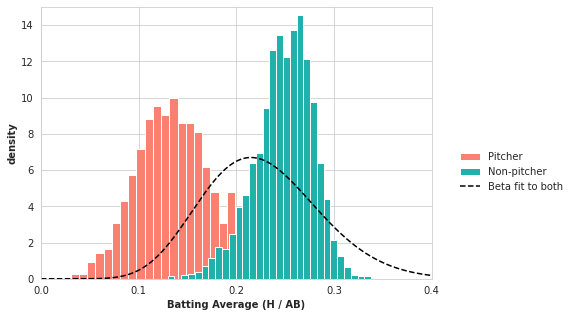

In [140]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # histplot
    min_atbat = 100
    ax.hist(bd.loc[(bd.AB > min_atbat) & (bd.Pitcher == True),"Avg"],bins=30,color="salmon",alpha=1, label="Pitcher",density=True)
    ax.hist(bd.loc[(bd.AB > min_atbat) & (bd.Pitcher == False),"Avg"],bins=30,color="lightseagreen",alpha=1,label="Non-pitcher",density=True)
    xvals = np.linspace(0,0.5,1000)
    beta_params = stats.beta.fit(bd.loc[(bd.AB > min_atbat), "Avg"],floc=0, fscale=1)
    ax.plot(xvals,stats.beta.pdf(xvals,beta_params[0],beta_params[1]),color='k',linestyle='--',label="Beta fit to both")

    ax.set_xlim(0,.4)
    ax.set_ylim(0,15)
    ax.set_xticks(np.arange(0,.5,0.1))
    ax.set_ylabel("density",fontweight="bold")
    ax.set_xlabel("Batting Average (H / AB)",fontweight="bold")
    ax.legend(frameon=False,loc='upper left',bbox_to_anchor=(1.05,.5))


## 9.2 Expectation-Maximization

First we need to randomly assign each player to a cluster.

In [210]:
import random
def random_assignment(bd):
    bd_trim = bd.loc[bd.AB > 20,:].copy()
    bd_trim.loc[:,"Cluster"] = random.choices(["A","B"],k=len(bd_trim.index))
    return bd_trim

bd_trim = random_assignment(bd)
bd_trim.sample(10)

,playerID,AB,H,yearID,Name,Avg,Pitcher,Cluster
2584,kilgupa01,46,4,1991.000000,Paul Kilgus,0.086957,True,B
953,clemeed02,179,47,1998.500000,Edgard Clemente,0.262570,False,A
2853,loaizes01,245,44,2000.857143,Esteban Loaiza,0.179592,True,B
4682,snellia01,192,18,2006.500000,Ian Snell,0.093750,True,B
2378,jacksda04,1769,425,2001.250000,Damian Jackson,0.240249,False,B
34,afenitr01,54,12,1989.500000,Troy Afenir,0.222222,False,A
2101,hebneri01,433,117,1983.500000,Richie Hebner,0.270208,False,A
2488,jonesji02,193,32,1989.500000,Jimmy Jones,0.165803,True,A
1067,cozarza01,2767,703,2014.000000,Zack Cozart,0.254066,False,A
4957,thomeji01,1358,352,2006.600000,Jim Thome,0.259205,False,A


## Figure 9.2
The density of batting averages among players assigned to cluster A or to cluster B.

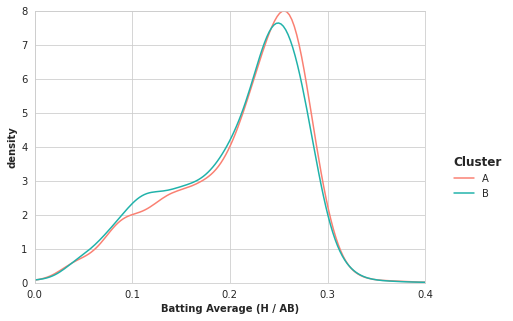

In [212]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    sns.kdeplot(bd_trim.loc[(bd_trim.Cluster == "A"),"Avg"],color="salmon",alpha=1, label="A")
    sns.kdeplot(bd_trim.loc[(bd_trim.Cluster == "B"),"Avg"],color="lightseagreen",alpha=1,label="B")

    ax.set_xlim(0,.4)
    ax.set_ylim(0,8)
    ax.set_xticks(np.arange(0,.5,0.1))
    ax.set_ylabel("density",fontweight="bold")
    ax.set_xlabel("Batting Average (H / AB)",fontweight="bold")
    ax.legend(frameon=False,loc='upper left',bbox_to_anchor=(1.05,.5))
    ax.get_legend().set_title("Cluster",prop = {'size':12,'weight': "bold"})
    ax.get_legend()._legend_box.align = "left"



In [213]:
# Get function for maximum likelihood estimation of beta params from Chapter 3
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    a, b = params[0], params[1]
    k = args[0] # Hits
    n = args[1] # At-bats
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))
    
    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf) #

def fit_betabinomial_mle(k,n,init_params=[5,10],bounds=[]):
    # MLE
    result = minimize(loglike_betabinom, x0=init_params,
                args=(k,n),method='L-BFGS-B', options={'disp': False, 'maxiter': 10000},bounds=[(1,1000),(1,1000)])
    return result

# Now for each cluster
resultA = fit_betabinomial_mle(bd_trim.loc[(bd_trim.Cluster == "A"),"H"],bd_trim.loc[(bd_trim.Cluster == "A"),"AB"])
resultB = fit_betabinomial_mle(bd_trim.loc[(bd_trim.Cluster == "B"),"H"],bd_trim.loc[(bd_trim.Cluster == "B"),"AB"])


## Figure 9.3 
Density within each of the randomly assigned clusters, along with a histogram of the cluster assignments.

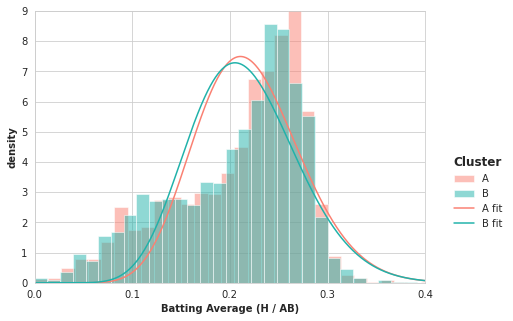

In [214]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # histplot
    min_atbat = 100
    ax.hist(bd_trim.loc[(bd_trim.Cluster == "A"),"Avg"],bins=30,color="salmon",alpha=0.5, label="A",density=True)
    ax.hist(bd_trim.loc[(bd_trim.Cluster == "B"),"Avg"],bins=30,color="lightseagreen",alpha=0.5,label="B",density=True)
    xvals = np.linspace(0,0.5,1000)
    ax.plot(xvals,stats.beta.pdf(xvals,resultA["x"][0],resultA["x"][1]),color='salmon',linestyle='-',label="A fit")
    ax.plot(xvals,stats.beta.pdf(xvals,resultB["x"][0],resultB["x"][1]),color='lightseagreen',linestyle='-',label="B fit")
    
    # Clean up
    ax.set_xlim(0,.4)
    ax.set_ylim(0,9)
    ax.set_xticks(np.arange(0,.5,0.1))
    ax.set_ylabel("density",fontweight="bold")
    ax.set_xlabel("Batting Average (H / AB)",fontweight="bold")

    ax.legend(frameon=False,loc='upper left',bbox_to_anchor=(1.05,.5))
    ax.get_legend().set_title("Cluster",prop = {'size':12,'weight': "bold"})
    ax.get_legend()._legend_box.align = "left"



Consider Jeff Abbott as in the book: (11 H / 42 AB)

In [215]:
pd.DataFrame({"Cluster":["A","B"], "H": [11, 11], "AB": [42,42],
              "Probability (%)": [round(np.exp(-loglike_betabinom([resultA["x"][0],resultA["x"][1]],11,42))*100,2),
                                  round(np.exp(-loglike_betabinom([resultB["x"][0],resultB["x"][1]],11,42))*100,2)]}).set_index("Cluster")

,H,AB,Probability (%)
Cluster,,,
A,11,42,9.20
B,11,42,8.79


We should assign him to Cluster B since it is a higher probability. Now we will apply this to each player in the DF.

In [216]:
def assignment(row,params):
    # Get params
    alphaA, betaA, alphaB, betaB = params
    # Calculate
    lA = np.exp(-loglike_betabinom([alphaA,betaA],row.H,row.AB))
    lB = np.exp(-loglike_betabinom([alphaB,betaB],row.H,row.AB))
    # Assign to new cluster
    row["New Cluster"] = ["A","B"][np.argmax([lA,lB])]
    return row

# Test
bd_trim.sample(5).apply(lambda row: assignment(row,[resultA["x"][0],resultA["x"][1],resultB["x"][0],resultB["x"][1]]),axis=1)


,playerID,AB,H,yearID,Name,Avg,Pitcher,Cluster,New Cluster
1142,daubabr01,40,6,2001.500000,Brian Daubach,0.150000,False,A,B
851,castrju01,2048,464,2003.294118,Juan Castro,0.226562,False,B,A
4623,siskdo01,38,4,1985.000000,Doug Sisk,0.105263,True,A,B
3885,peveyma01,41,9,1989.000000,Marty Pevey,0.219512,False,A,A
2210,hillri01,224,25,2012.000000,Rich Hill,0.111607,True,A,B


Lets look at a few iterations of this process to see how they change.

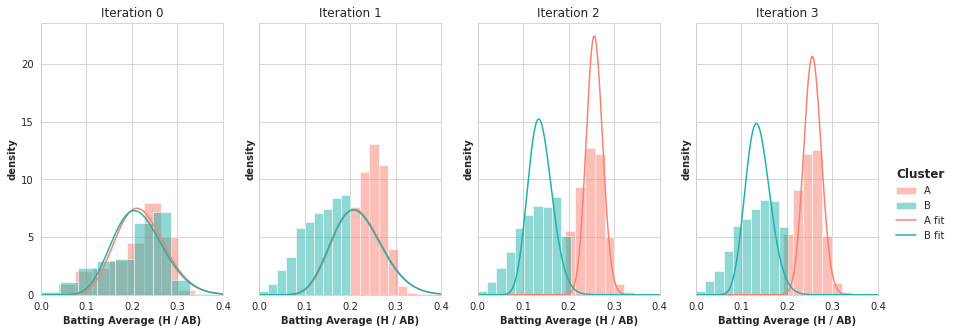

In [217]:
def assignment(row,params):
    # Get params
    alphaA, betaA, alphaB, betaB = params
    # Calculate
    lA = np.exp(-loglike_betabinom([alphaA,betaA],row.H,row.AB))
    lB = np.exp(-loglike_betabinom([alphaB,betaB],row.H,row.AB))
    # Assign to new cluster
    row["Cluster"] = ["A","B"][np.argmax([lA,lB])]
    return row

# Make figure
bd_trim = random_assignment(bd)
with sns.axes_style("whitegrid"):
    # Fig
    # Make figure
    fig, allax = plt.subplots(1,4,sharey=True,sharex=True)
    # flatax = ax.flatten()
    fig.set_size_inches(15,5)

    for cnt,ax in enumerate(allax):
        # histplot
        min_atbat = 100
        ax.hist(bd_trim.loc[(bd_trim.Cluster == "A"),"Avg"],color="salmon",alpha=0.5, label="A",density=True)#,bins=30)
        ax.hist(bd_trim.loc[(bd_trim.Cluster == "B"),"Avg"],color="lightseagreen",alpha=0.5,label="B",density=True)#,bins=30)
        xvals = np.linspace(0,0.5,1000)
        ax.plot(xvals,stats.beta.pdf(xvals,resultA["x"][0],resultA["x"][1]),color='salmon',linestyle='-',label="A fit")
        ax.plot(xvals,stats.beta.pdf(xvals,resultB["x"][0],resultB["x"][1]),color='lightseagreen',linestyle='-',label="B fit")

        # Now  for each cluster
        resultA = fit_betabinomial_mle(bd_trim.loc[(bd_trim.Cluster == "A"),"H"],bd_trim.loc[(bd_trim.Cluster == "A"),"AB"])
        resultB = fit_betabinomial_mle(bd_trim.loc[(bd_trim.Cluster == "B"),"H"],bd_trim.loc[(bd_trim.Cluster == "B"),"AB"])
        bd_trim = bd_trim.apply(lambda row: assignment(row,[resultA["x"][0],resultA["x"][1],resultB["x"][0],resultB["x"][1]]),axis=1)

        # Clean up
        ax.set_xlim(0,.4)
        # ax.set_ylim(0,12)
        ax.set_xticks(np.arange(0,.5,0.1))
        ax.set_ylabel("density",fontweight="bold")
        ax.set_xlabel("Batting Average (H / AB)",fontweight="bold")
        ax.set_title("Iteration {}".format(cnt))
    
    ax.legend(frameon=False,loc='upper left',bbox_to_anchor=(1.05,.5))
    ax.get_legend().set_title("Cluster",prop = {'size':12,'weight': "bold"})

This already looks  pretty good but lets run it until we reach some kind of convergence...

In [267]:
def expectation_maximization(bd_trim,num_iterations=50,criterion=0.01):
    # for each iteration
    cnt = 0
    for ii in range(num_iterations):
        # Get old cluster assignment
        old_cluster = bd_trim.loc[:,"Cluster"].tolist()

        # Now  for each cluster
        resultA = fit_betabinomial_mle(bd_trim.loc[(bd_trim.Cluster == "A"),"H"],bd_trim.loc[(bd_trim.Cluster == "A"),"AB"])
        resultB = fit_betabinomial_mle(bd_trim.loc[(bd_trim.Cluster == "B"),"H"],bd_trim.loc[(bd_trim.Cluster == "B"),"AB"])

        # Reassign clusters
        bd_trim = bd_trim.apply(lambda row: assignment(row,[resultA["x"][0],resultA["x"][1],resultB["x"][0],resultB["x"][1]]),axis=1)

        # Find out how many have changed
        count = [val for val in old_cluster if val in bd_trim.Cluster.tolist()]
        percentDiff = (1 - len(count)/len(bd_trim.Cluster))
        cnt += 1
        if criterion != []:
            if percentDiff < criterion:
                break
    
    print("EM completed {} iterations. {}% between ultimate and penultimate iterations.".format(cnt,percentDiff))
    return bd_trim, resultA, resultB
        
bd_trim = random_assignment(bd)
bd_trim, resultA, resultB = expectation_maximization(bd_trim,num_iterations=10,criterion=[])#criterion=0.0001)#criterion=[])#
bd_trim.head()

EM completed 10 iterations. 0.0% between ultimate and penultimate iterations.


,playerID,AB,H,yearID,Name,Avg,Pitcher,Cluster
4,abbotje01,42,11,2001.0,Jeff Abbott,0.261905,False,B
5,abbotji01,21,2,1999.0,Jim Abbott,0.095238,True,A
6,abbotku01,1860,475,1997.5,Kurt Abbott,0.255376,False,B
7,abbotky01,31,3,1993.5,Kyle Abbott,0.096774,True,A
9,abercre01,386,86,2007.0,Reggie Abercrombie,0.222798,False,B


We can see that we reach convergence in only two iterations! This is apparent in the plot above where we see that iteration 2 and 3 look identical. 

Now lets get the pitchers in the book. Technically one of them has more than 100 AB (unlike in the book, likely because we include more years), but its not a big deal. 

In [262]:
which_batters = ["Jose De jesus","Juan Nicasio","Mike Mahoney","Robinson Cancel","Mike Busch","Ryan Shealy"]
bd_trim.loc[bd_trim.Name.isin(which_batters), :].sort_values(by="Avg")

,playerID,AB,H,yearID,Name,Avg,Pitcher,Cluster
1208,dejesjo01,100,11,1990.500000,Jose De jesus,0.110000,True,A
3518,nicasju01,123,15,2014.625000,Juan Nicasio,0.121951,True,A
2983,mahonmi02,100,18,2002.333333,Mike Mahoney,0.180000,False,A
763,cancero01,100,20,2006.750000,Robinson Cancel,0.200000,False,A
701,buschmi01,100,22,1995.500000,Mike Busch,0.220000,False,A
4571,shealry01,100,32,2005.500000,Ryan Shealy,0.320000,False,B


## Figure 9.7
The likelihood that cluster A or cluster B would generate each of these six players’ records.

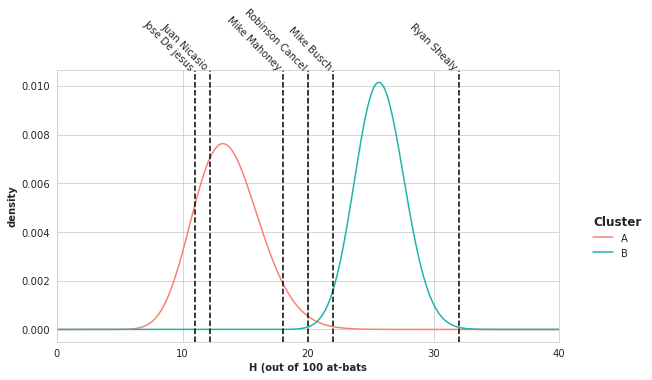

In [286]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot()

    # histplot
    xvals = np.linspace(0,0.5,1000)
    pdf_A = stats.beta.pdf(xvals,resultA["x"][0],resultA["x"][1])
    ax.plot(xvals,pdf_A/np.sum(pdf_A),color='salmon',linestyle='-',label="A")
    pdf_B = stats.beta.pdf(xvals,resultB["x"][0],resultB["x"][1])
    ax.plot(xvals,pdf_B/np.sum(pdf_B),color='lightseagreen',linestyle='-',label="B")
    
    for row in bd_trim.loc[bd_trim.Name.isin(which_batters), :].itertuples():
        ax.axvline(x=row.H/row.AB,color='k',linestyle='--')
        ax.text(x=row.H/row.AB,y=ax.get_ylim()[1],s=row.Name,rotation=-45,ha="right")

    # Clean up
    ax.set_xlim(0,.4)
    # ax.set_ylim(0,9)
    ax.set_xticks([0,.10,.20,.30,.40])
    ax.set_xticklabels(list(map(str,[0,10,20,30,40])))
    ax.set_ylabel("density",fontweight="bold")
    ax.set_xlabel("H (out of 100 at-bats",fontweight="bold")

    ax.legend(frameon=False,loc='upper left',bbox_to_anchor=(1.05,.5))
    ax.get_legend().set_title("Cluster",prop = {'size':12,'weight': "bold"})
    ax.get_legend()._legend_box.align = "left"


## Figure 9.8
The posterior probability that each of the 6 players with 100 at-bats is in the pitcher cluster.

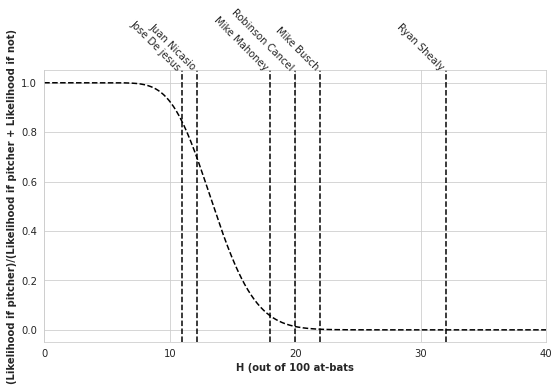

In [301]:
def compute_likelihood_of_A(row,params):
    # Get params
    alphaA, betaA, alphaB, betaB = params
    # Calculate
    lA = np.exp(-loglike_betabinom([alphaA,betaA],row.H,row.AB))
    lB = np.exp(-loglike_betabinom([alphaB,betaB],row.H,row.AB))
    # ratio
    return lA/(lA+lB)


# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot()

    # Cumulative 
    xvals = np.linspace(0,0.5,1000)
    pdf_A = stats.beta.pdf(xvals,resultA["x"][0],resultA["x"][1])
    ax.plot(xvals,1-np.cumsum((pdf_A/np.sum(pdf_A))),color='k',linestyle='--',label="B")

    for row in bd_trim.loc[bd_trim.Name.isin(which_batters), :].sort_values(by="Avg").itertuples():
        lratio = compute_likelihood_of_A(row,[resultA["x"][0],resultA["x"][1],resultB["x"][0],resultB["x"][1]])
        ax.axvline(x=row.H/row.AB,color='k',linestyle='--')
        ax.text(x=row.H/row.AB,y=ax.get_ylim()[1],s=row.Name,rotation=-45,ha="right")
        
    # Clean up
    ax.set_xlim(0,.4)
    # ax.set_ylim(0,9)
    ax.set_xticks([0,.10,.20,.30,.40])
    ax.set_xticklabels(list(map(str,[0,10,20,30,40])))
    ax.set_ylabel("(Likelihood if pitcher)/(Likelihood if pitcher + Likelihood if not)",fontweight="bold")
    ax.set_xlabel("H (out of 100 at-bats",fontweight="bold")


Now lets compute a confusion matrix to see how many players were incorrectly assigned to the wrong cluster.

In [308]:
from sklearn.metrics import confusion_matrix

confusion_matrix(bd_trim.Pitcher,bd_trim.Cluster=="A")

array([[2239,  341],
       [ 125,  944]])

## Figure 9.9

Posterior distributions for the batting average of each of the six players with 100 at-bats. Each player’s raw batting average is shown as a dashed vertical line.

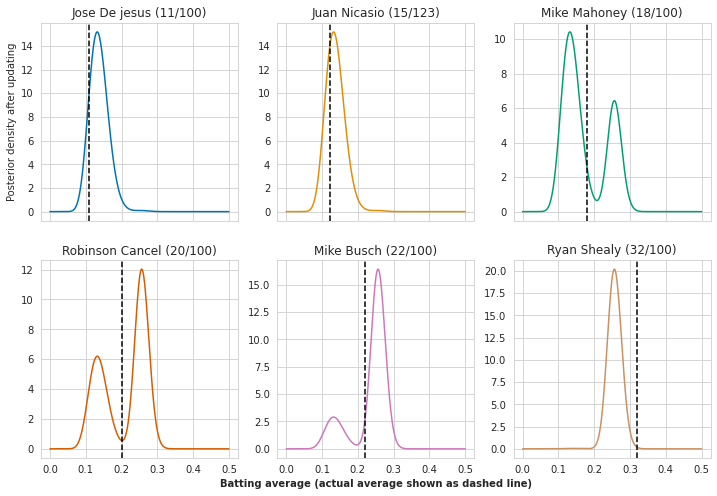

In [326]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(2,3,sharey=False,sharex=True)
    # flatax = ax.flatten()
    fig.set_size_inches(12,8)

    # Compute pdf
    xvals = np.linspace(0,0.5,1000)
    pdf_A = stats.beta.pdf(xvals,resultA["x"][0],resultA["x"][1])
    pdf_B = stats.beta.pdf(xvals,resultB["x"][0],resultB["x"][1])

    # Loop through each axis
    clrs = sns.color_palette("colorblind",n_colors=len(which_batters))
    for (thisax,row,clr) in zip(ax.flatten(),bd_trim.loc[bd_trim.Name.isin(which_batters), :].sort_values(by="Avg").itertuples(),clrs):
        lA = compute_likelihood_of_A(row,[resultA["x"][0],resultA["x"][1],resultB["x"][0],resultB["x"][1]])
        thispdf = lA*(pdf_A)+ (1-lA)*(pdf_B)
        thisax.plot(xvals,thispdf,color=clr,label=row.Name)
        thisax.axvline(x=row.Avg,color='k',linestyle='--')
        thisax.set_title("{} ({}/{})".format(row.Name,row.H,row.AB))

    ax[1,1].set_xlabel("Batting average (actual average shown as dashed line)",fontweight="bold")
    ax[0,0].set_ylabel("Posterior density after updating")
        
